In [1]:
!rm -rf /content/*

DATASET_NUM = 2
src = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{DATASET_NUM}'
frames_path = f'{src}/frames.csv'
polygons_path = f'{src}/polygons.mat'

!wget {frames_path}
!wget {polygons_path}

target_directory = 'images'
!mkdir -p {target_directory}

frames = []
NUM_IMAGES = 20

assert 0 < NUM_IMAGES <= 100

with open('frames.csv', 'r') as f:
  lines = f.readlines()
  for i, line in enumerate(lines):
    if i == NUM_IMAGES: break

    line = line.strip()
    frames.append(line.split('.')[0])

    image_url = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{DATASET_NUM}/{line}'
    !wget -P {target_directory} {image_url}

--2025-01-09 18:41:51--  http://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv [following]
--2025-01-09 18:41:51--  https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/2/frames.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1600 (1.6K) [text/plain]
Saving to: ‘frames.csv’

frames.csv          100%[===================>]   1.56K  --.-KB/s    in 0s      

2025-01-09 18:41:51 (30.3 MB/s) - ‘frames.csv’ saved [1600/1600]

URL transformed to HTTPS due to an HSTS

In [3]:
import scipy.io
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
mat = scipy.io.loadmat('polygons.mat')
labelled_frames = []

for i, frame in enumerate(frames):
  labelled_frame = {
    'frame': frame,
    'myleft': mat['polygons'][0][i][0],
    'myright': mat['polygons'][0][i][1],
    'yourleft': mat['polygons'][0][i][2],
    'yourright': mat['polygons'][0][i][3]
  }

  labelled_frames.append(labelled_frame)

In [7]:
def get_labelled_frame(frame_name):
  labelled_frame = [label for label in labelled_frames if label['frame'] == frame_name]

  if len(labelled_frame) == 0:
    return

  return labelled_frame[0]


def get_segmentation_mask(frame):
  assert type(frame) == dict, 'Frame must be a dictionary'

  img_mask = np.zeros((720, 1280), np.float32)

  if frame['myleft'].shape != (1, 0):
    myleft_points = [(int(x), int(y)) for x, y in frame['myleft']]
    cv2.fillPoly(img_mask, [np.array(myleft_points, dtype=np.int32)], 255)
  if frame['myright'].shape != (1, 0):
    myright_points = [(int(x), int(y)) for x, y in frame['myright']]
    cv2.fillPoly(img_mask, [np.array(myright_points, dtype=np.int32)], 255)
  if frame['yourleft'].shape != (1, 0):
    yourleft_points = [(int(x), int(y)) for x, y in frame['yourleft']]
    cv2.fillPoly(img_mask, [np.array(yourleft_points, dtype=np.int32)], 255)
  if frame['yourright'].shape != (1, 0):
    yourright_points = [(int(x), int(y)) for x, y in frame['yourright']]
    cv2.fillPoly(img_mask, [np.array(yourright_points, dtype=np.int32)], 255)

  return img_mask

frame_0359


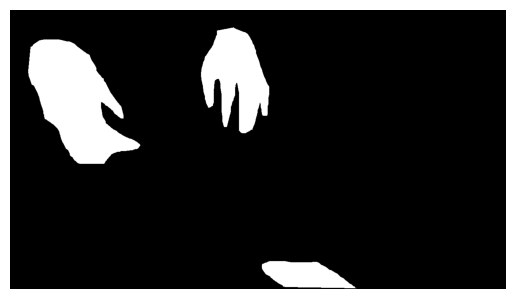

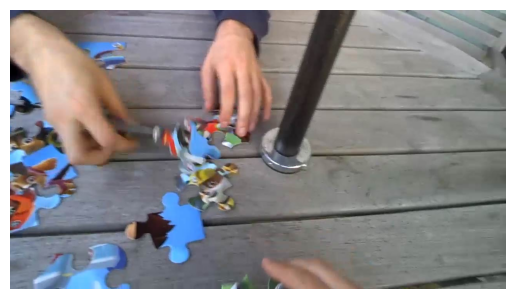

<function matplotlib.pyplot.show(close=None, block=None)>

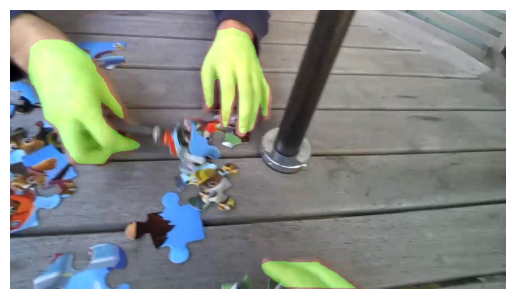

In [10]:
FRAME_NUM = 13

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

frame = get_labelled_frame(frame_name)
mask = get_segmentation_mask(frame)
mask[mask>0] = 1
mask = mask.astype(np.uint8)

plt.figure()
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

img = cv2.imread(f'images/{frame_name}.jpg')[:,:,::-1]

plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

mask_colored = np.zeros_like(img)
mask_colored[:, :, 1] = mask * 255
overlay_image = img.copy()
overlay_image[mask == 1] = cv2.addWeighted(img[mask == 1], 1, mask_colored[mask == 1], 0.35, 0)
plt.imshow(overlay_image, cmap='gray')
plt.axis('off')
plt.show

# Color-based segmentation


In [19]:
import cv2
import numpy as np

def color_segmentation(img_path):
  image = cv2.imread(img_path)[:, :, ::-1]
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

  lower_skin = np.array([0, 45,  82])
  upper_skin = np.array([17, 177, 255])

  skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  skin_mask = cv2.erode(skin_mask, kernel, iterations=3)
  skin_mask = cv2.dilate(skin_mask, kernel, iterations=1)

  cnts, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  min_contour_area = 10000
  filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

  mask = np.zeros_like(skin_mask)
  cv2.drawContours(mask, filtered_contours, -1, 1, thickness=cv2.FILLED)

  return mask

### dev

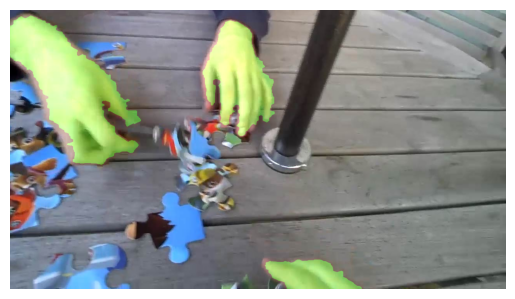

In [143]:
import cv2
import numpy as np

image = cv2.imread(f'images/{frame_name}.jpg')[:, :, ::-1]

# Original image
plt.figure(figsize=(16,16))
plt.subplot(3, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Blurred image
blurred = cv2.GaussianBlur(image, (11, 11), 0)
plt.subplot(3, 3, 2)
plt.imshow(blurred)
plt.title('Blurred Image')
plt.axis('off')

hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define the HSV range for skin detection
lower_skin = np.array([0, 50, 80])    # Lower bound of HSV for skin
upper_skin = np.array([20, 255, 255])  # Upper bound of HSV for skin

# Skin mask
skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
plt.subplot(3, 3, 3)
plt.imshow(skin_mask, cmap='gray')
plt.title('Skin Mask')
plt.axis('off')

# Apply morphological operations to clean up the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
skin_mask = cv2.erode(skin_mask, kernel, iterations=3)
skin_mask = cv2.dilate(skin_mask, kernel, iterations=3)
skin_mask = cv2.GaussianBlur(skin_mask, (5, 5), 0)

plt.subplot(3, 3, 4)
plt.imshow(skin_mask, cmap='gray')
plt.title('Skin Mask claned')
plt.axis('off')

# Skin segmented
skin_segment = cv2.bitwise_and(image, image, mask=skin_mask)
plt.subplot(3, 3, 5)
plt.imshow(skin_segment)
plt.title('Skin Segmented')
plt.axis('off')


# Find the largest contour
cnts, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

min_contour_area = 10000
# cnt = max(cnts, key=cv2.contourArea)  # Largest contour by area
filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

# Prepare an output mask
mask = np.zeros_like(skin_mask)  # Create a blank mask

# Draw the largest contour on the mask
cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

# Apply the mask to the original image
out = cv2.bitwise_and(image, image, mask=mask)

# Display the output
plt.subplot(3, 3, 6)
plt.imshow(out)
plt.title('Contours above certan threshold')
plt.axis('off')


out_binary = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
out_binary[out_binary>0] = 1
plt.subplot(3, 3, 7)
plt.imshow(out_binary, cmap='gray')
plt.title('Binary Contours above certain threshold')
plt.axis('off')

plt.show()

# Edge-based segmentation attempt

## dev


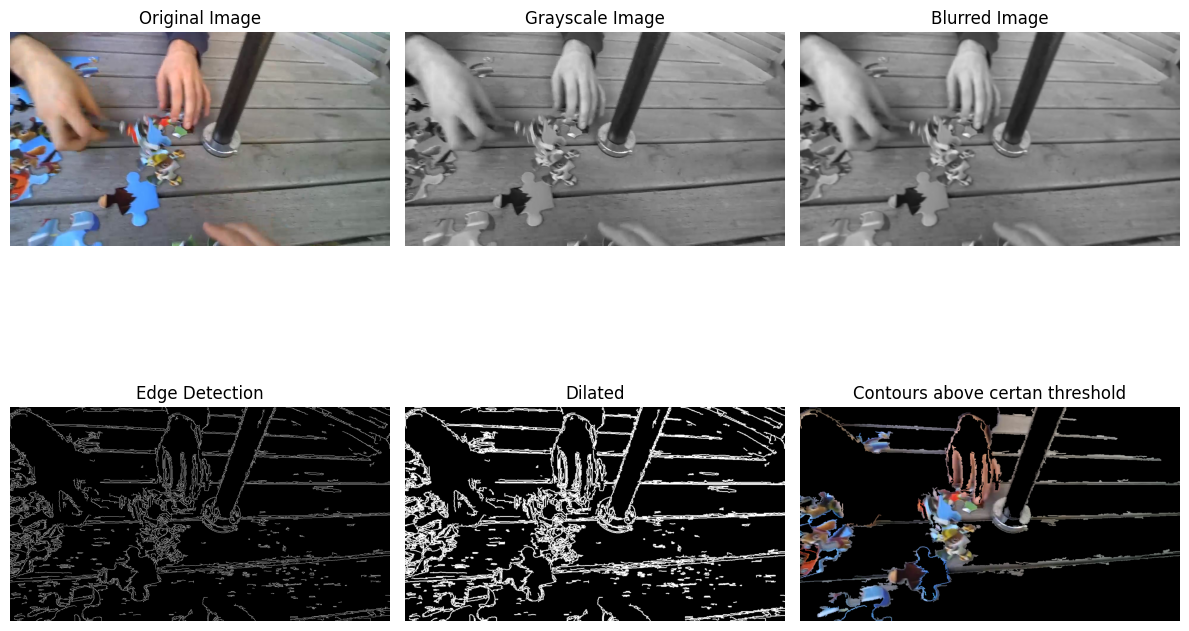

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(f'images/{frame_name}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,12))
# Original image
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Grayscale image
plt.subplot(3, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Blurred image
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
plt.subplot(3, 3, 3)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

# Edge-detected image
edges = cv2.Canny(gray, 20, 70)
plt.subplot(3, 3, 4)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')


# Edge-detected image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilated = cv2.dilate(edges, kernel, iterations=1)
plt.subplot(3, 3, 5)
plt.imshow(dilated, cmap='gray')
plt.title('Dilated')
plt.axis('off')


# Find the largest contour
cnts, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

min_contour_area = 10000
# cnt = max(cnts, key=cv2.contourArea)  # Largest contour by area
filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

# Prepare an output mask
mask = np.zeros_like(dilated)  # Create a blank mask

# Draw the largest contour on the mask
cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

# Apply the mask to the original image
out = cv2.bitwise_and(image, image, mask=mask)

# Display the output
plt.subplot(3, 3, 6)
plt.imshow(out)
plt.title('Contours above certan threshold')
plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## vertical edges

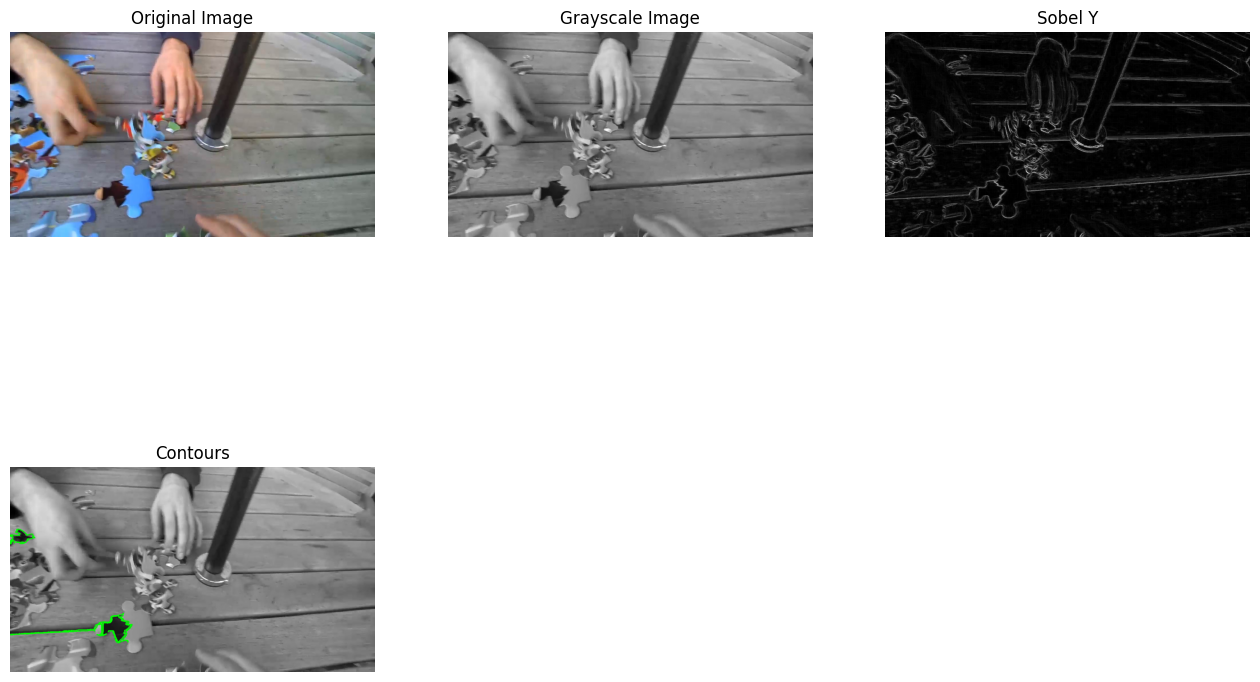

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(f'images/{frame_name}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(16,16))
# Original image
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Grayscale image
plt.subplot(3, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

scale = 1
delta = 0
ddepth = cv2.CV_16S

grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.subplot(3, 3, 3)
plt.imshow(grad, cmap='gray')
plt.title('Sobel Y')
plt.axis('off')



_, thresholded = cv2.threshold(grad, 50, 255, cv2.THRESH_BINARY)


contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


contour_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Convert grayscale to color for drawing contours

filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 2000]

cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)  # Green contours with thickness of 2

# Show the resulting image
plt.subplot(3, 3, 4)
plt.imshow(contour_image)
plt.title('Contours')
plt.axis('off')


plt.show()

## another approach

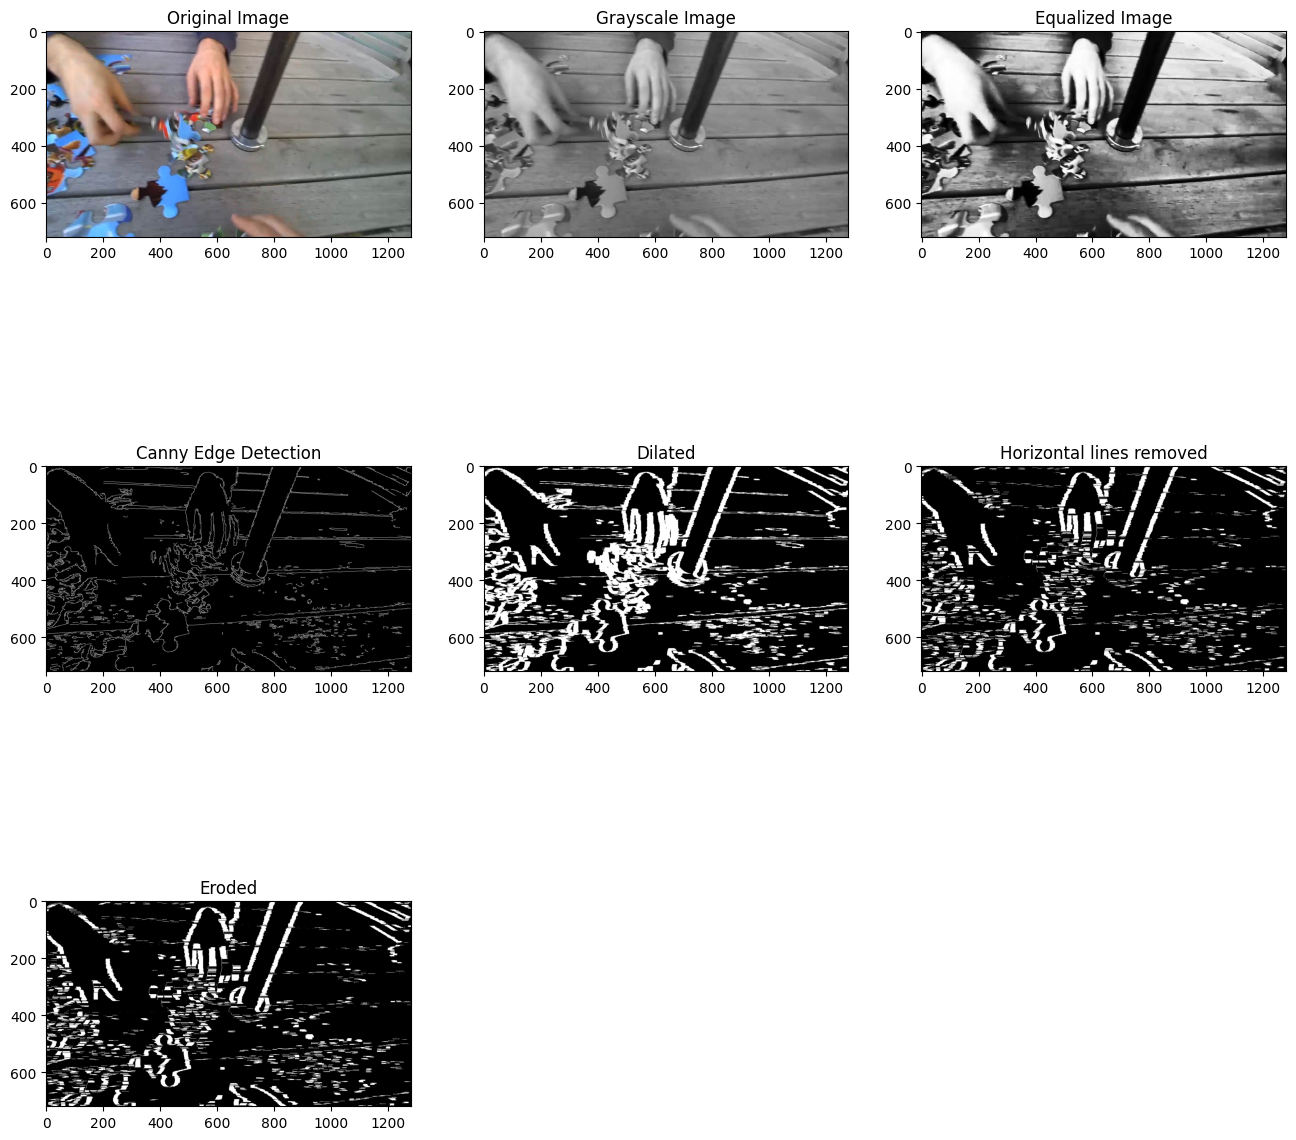

In [23]:
def sgmnt(image_path):
  #original image
  plt.figure(figsize=(16,16))
  plt.subplot(3, 3, 1)
  image = cv2.imread(image_path)[:,:,::-1]
  plt.title('Original Image')
  plt.imshow(image)

  #gray image
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  plt.subplot(3, 3, 2)
  plt.title('Grayscale Image')
  plt.imshow(gray_image, cmap='gray')

  # equalized image
  equalized_image = cv2.equalizeHist(gray_image)
  plt.subplot(3, 3, 3)
  plt.title('Equalized Image')
  plt.imshow(equalized_image, cmap='gray')

  # canny edge detector
  canny = cv2.Canny(equalized_image, 100, 200)
  plt.subplot(3, 3, 4)
  plt.title('Canny Edge Detection')
  plt.imshow(canny, cmap='gray')

  # dilation
  kernel = np.ones((1,15), np.uint8)
  dilated = cv2.dilate(canny, kernel, iterations=1)
  plt.subplot(3, 3, 5)
  plt.title('Dilated')
  plt.imshow(dilated, cmap='gray')

  # removal of horizontal eges
  kernel = np.ones((1,30), np.uint8)
  horizontal = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)
  result = dilated - horizontal
  plt.subplot(3, 3, 6)
  plt.title('Horizontal lines removed')
  plt.imshow(result, cmap='gray')

  # erosion
  kernel = np.ones((1, 1), np.uint8)
  eroded = cv2.erode(result, kernel, iterations=1)
  plt.subplot(3, 3, 7)
  plt.title('Eroded')
  plt.imshow(eroded, cmap='gray')




  # kernel = np.ones((3,3), np.uint8)
  # opened = cv2.morphologyEx(canny, cv2.MORPH_OPEN, kernel)
  # plt.subplot(3, 3, 5)
  # plt.title('Opened Image')
  # plt.imshow(opened, cmap='gray')

  # closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
  # plt.subplot(3, 3, 6)
  # plt.title('Closed Image')
  # plt.imshow(closed, cmap='gray')

  # adaptive_thresh_mean = cv2.adaptiveThreshold(equalized_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
  #                                               cv2.THRESH_BINARY, 11, 2)
  # plt.subplot(3, 3, 4)
  # plt.imshow(adaptive_thresh_mean, cmap='gray')
  # plt.title('Adaptive Thresholding (Mean)')

  # # Adaptive Gaussian thresholding: Local neighborhood weighted sum is used for thresholding
  # adaptive_thresh_gaussian = cv2.adaptiveThreshold(equalized_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
  #                                                   cv2.THRESH_BINARY, 11, 2)
  # plt.subplot(3, 3, 5)
  # plt.imshow(adaptive_thresh_gaussian, cmap='gray')
  # plt.title('Adaptive Thresholding (Gaussian)')

FRAME_NUM = 13

fn = labelled_frames[FRAME_NUM]['frame']
sgmnt(f'images/{fn}.jpg')

# Edge-based method attempt 2

## Dev

In [16]:
import cv2

def get_larger_contours(contours, size_thresh=8000):
  large_contours = []
  for c in contours:
    if cv2.contourArea(c) > size_thresh:
      large_contours.append(c)
  return large_contours

def get_smooth_contours(contours, convex_ratio=0.62):
  smooth_contours = []
  for c in contours:
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    contour_area = cv2.contourArea(c)
    if hull_area > 0:
      if contour_area / hull_area > convex_ratio:
        smooth_contours.append(c)
  return smooth_contours


def get_rectangle_contours(contours, rectange_ratio_low=1.12, rectange_ratio_upper=2.6):
  rect_contours = []
  for c in contours:
    rect = cv2.minAreaRect(c)
    (center, (width, height), angle) = rect
    if angle >= 45:
      tmp = width
      width = height
      height = tmp
    ratio = height/width if width != 0 else 0
    if ratio > rectange_ratio_low and ratio < rectange_ratio_upper:
      rect_contours.append(c)
  return rect_contours

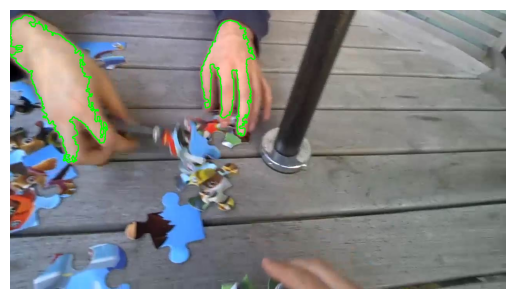

In [22]:
import cv2
import numpy as np

FRAME_NUM = 13
fn = labelled_frames[FRAME_NUM]['frame']
image_path = f'images/{fn}.jpg'

plt.figure(figsize=(16,23))

#Original image
image = cv2.imread(image_path)[:,:,::-1]
plt.subplot(5, 3, 1)
plt.imshow(image)
plt.title('Original Image')

#Gray image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.subplot(5, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')

# Histogram equalization
histeq = cv2.equalizeHist(gray)
plt.subplot(5, 3, 3)
plt.imshow(histeq, cmap='gray')
plt.title('Histogram equalization')

# Mean thresholding image
thresh3 = cv2.adaptiveThreshold(
    histeq,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=7,
    C=2
)
plt.subplot(5, 3, 4)
plt.imshow(thresh3, cmap='gray')
plt.title('Mean adaptive thresholded image')

# Min filtered
min_filtered = cv2.erode(thresh3, np.ones((3, 3), np.uint8), iterations=1)
plt.subplot(5, 3, 6)
plt.imshow(min_filtered, cmap='gray')
plt.title('Min filtered')

# Median Blur on min filtered
median_filtered = cv2.medianBlur(min_filtered, 5)
plt.subplot(5, 3, 8)
plt.imshow(median_filtered, cmap='gray')
plt.title('Median filter on min filtered')

# Find countours
contours, _ = cv2.findContours(median_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
all_cnt_img = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)
plt.subplot(5, 3, 9)
plt.imshow(all_cnt_img)
plt.title('All contours')

large_contours = get_larger_contours(contours)
large_cnt_img = cv2.drawContours(image.copy(), large_contours, -1, (0, 255, 0), 2)
plt.subplot(5, 3, 10)
plt.imshow(large_cnt_img)
plt.title('Filtered contours: large')

smooth_contours = get_smooth_contours(large_contours)
smooth_cnt_img = cv2.drawContours(image.copy(), smooth_contours, -1, (0, 255, 0), 2)
plt.subplot(5, 3, 11)
plt.imshow(smooth_cnt_img)
plt.title('Filtered contours: large + smooth')


rect_contours = get_rectangle_contours(smooth_contours)
rect_cnt_img = cv2.drawContours(image.copy(), rect_contours, -1, (0, 255, 0), 2)
plt.subplot(5, 3, 12)
plt.imshow(rect_cnt_img)
plt.title('Filtered contours: large + smooth + rectangle')

# Prepare an output mask
mask = np.zeros_like(gray)
cv2.drawContours(mask, rect_contours, -1, 255, thickness=cv2.FILLED)
plt.subplot(5, 3, 13)
plt.imshow(mask, cmap='gray')
plt.title('Mask')


kernel = np.ones((11,1), np.uint8)
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.subplot(5, 3, 14)
plt.imshow(closed, cmap='gray')
plt.title('Rectangle closed')


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
closed = cv2.dilate(closed, kernel, iterations=3)
plt.subplot(5, 3, 15)
plt.imshow(closed, cmap='gray')
plt.title('Ellipse dilated')
plt.show()

## function

In [14]:
def contour_based_segmentation(image_path):
  #Original image
  image = cv2.imread(image_path)[:,:,::-1]
  #Gray image
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  # Histogram equalization
  histeq = cv2.equalizeHist(gray)

  # Gaussian adaptive thresholded image
  thresh2 = cv2.adaptiveThreshold(
      histeq,
      maxValue=255,
      adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      thresholdType=cv2.THRESH_BINARY,
      blockSize=7,
      C=2
  )

  # Min filtered
  min_filtered = cv2.erode(thresh2, np.ones((3, 3), np.uint8), iterations=1)
  # Median filter on min filtered
  median_filtered = cv2.medianBlur(min_filtered, 5)
  # Find countours
  contours, _ = cv2.findContours(median_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # filter contours
  contours = get_rectangle_contours(get_smooth_contours(get_larger_contours(contours)))

  # Prepare an output mask
  mask = np.zeros_like(gray)
  cv2.drawContours(mask, contours, -1, 1, thickness=cv2.FILLED)

  # opening
  kernel = np.ones((11,1), np.uint8)
  closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

  # dilation
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
  dilated = cv2.dilate(closed, kernel, iterations=2)
  return dilated

#IoU metric function

In [12]:
def evaluate_iou(segmented_imgs, ground_truth_imgs):
  total_intersection_area = 0
  total_union_area = 0
  for si, gti in zip(segmented_imgs, ground_truth_imgs):
    intersection = cv2.bitwise_and(si, gti)
    union = cv2.bitwise_or(si, gti)

    total_intersection_area += np.sum(intersection)
    total_union_area += np.sum(union)

  return total_intersection_area / total_union_area if total_union_area > 0 else 0

## Evaluation


In [29]:
color_segmented_images = []
contour_segmented_images = []
watershed_segmented_images = []
ground_truth_images = []

print(len(frames))
for img_name in frames:
  color_segmented_images.append(color_segmentation(f'images/{img_name}.jpg'))
  contour_segmented_images.append(contour_based_segmentation(f'images/{img_name}.jpg'))
  watershed_segmented_images.append(watershed_with_color(f'images/{img_name}.jpg'))

  frame = get_labelled_frame(img_name)
  mask = get_segmentation_mask(frame)
  binary_overlay = np.zeros(mask.shape, dtype=np.uint8)
  binary_overlay[mask == 255] = 1
  ground_truth_images.append(binary_overlay)
print("color_based acccuracy is: ", evaluate_iou(color_segmented_images, ground_truth_images))
print("contour_based acccuracy is: ", evaluate_iou(contour_segmented_images, ground_truth_images))
print("watershed + color acccuracy is: ", evaluate_iou(watershed_segmented_images, ground_truth_images))

20
color_based acccuracy is:  0.7294723335917136
contour_based acccuracy is:  0.06327357864056968
watershed + color acccuracy is:  0.6978251880048032


## HSV visualization

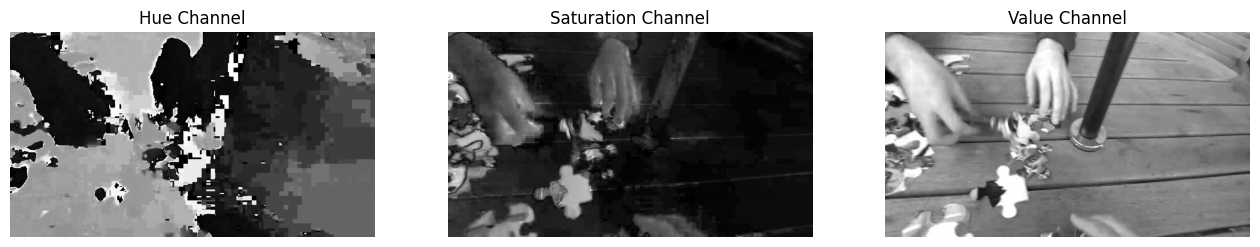

In [27]:
import cv2
import matplotlib.pyplot as plt

FRAME_NUM = 13

fn = labelled_frames[FRAME_NUM]['frame']

image = cv2.imread(f'images/{fn}.jpg')
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv_image)


plt.figure(figsize=(16, 7))

# Hue channel
plt.subplot(1, 3, 1)
plt.imshow(hue, cmap='gray')
plt.title('Hue Channel')
plt.axis('off')

# Saturation channel
plt.subplot(1, 3, 2)
plt.imshow(saturation, cmap='gray')
plt.title('Saturation Channel')
plt.axis('off')

# Value channel
plt.subplot(1, 3, 3)
plt.imshow(value, cmap='gray')
plt.title('Value Channel')
plt.axis('off')

plt.show()

In [26]:
def watershed(image_path):
  #Original image
  image = cv2.imread(image_path)[:,:,::-1]
  #Gray image
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  #HSV image
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  hue, saturation, value = cv2.split(hsv_image)
  # Histogram equalization
  histeq = cv2.equalizeHist(gray)

  # Gaussian adaptive thresholded image
  thresh2 = cv2.adaptiveThreshold(
      histeq,
      maxValue=255,
      adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      thresholdType=cv2.THRESH_BINARY,
      blockSize=7,
      C=2
  )

  # Min filtered
  min_filtered = cv2.erode(thresh2, np.ones((3, 3), np.uint8), iterations=1)
  # Median filter on min filtered
  median_filtered = cv2.medianBlur(min_filtered, 5)
  ncomp, lables = cv2.connectedComponents(min_filtered)
  print(f"number of conneccted components", ncomp)
  watershed = cv2.watershed(image, lables)
  return watershed

def watershed_with_color(image_path):
  #Original image
  image = cv2.imread(image_path)[:,:,::-1]
  #Gray image
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  #HSV image
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  hue, saturation, value = cv2.split(hsv_image)
  # Histogram equalization
  histeq = cv2.equalizeHist(gray)

  # Gaussian adaptive thresholded image
  thresh2 = cv2.adaptiveThreshold(
      histeq,
      maxValue=255,
      adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      thresholdType=cv2.THRESH_BINARY,
      blockSize=7,
      C=2
  )

  # Min filtered
  min_filtered = cv2.erode(thresh2, np.ones((3, 3), np.uint8), iterations=1)
  # Median filter on min filtered
  median_filtered = cv2.medianBlur(min_filtered, 5)
  ncomp, lables = cv2.connectedComponents(min_filtered)


  watershed = cv2.watershed(image, lables)
  binary_mask = color_segmentation(image_path)
  final = binary_mask.copy()

  unique_labels = np.unique(watershed)

  for label in unique_labels:
    if label == -1:
      continue

    single_contour = np.zeros_like(binary_mask, dtype=np.uint8)
    single_contour[watershed == label] = 1
    contour_area = np.sum(single_contour)
    overlap = cv2.bitwise_and(binary_mask, single_contour)

    if(np.sum(overlap) > 0.50 *contour_area):
      final = np.bitwise_or(final, single_contour)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,30))
  opened = cv2.morphologyEx(final, cv2.MORPH_OPEN, kernel)
  return opened

# img = watershed(f'images/{FRAME_NUM}.jpg')
# plt.figure(figsize=(16,10))
# plt.subplot(2,3,1)
# plt.imshow(img, cmap="gray")
# plt.title("waterhsed")

# plt.subplot(2,3,2)
# plt.imshow(color_segmentation(f'images/{fn}.jpg'), cmap="gray")
# plt.title("color")

# wwc = watershed_with_color(f'images/{fn}.jpg')
# plt.subplot(2,3,3)
# plt.imshow(wwc, cmap="gray")
# plt.title("watershed + color")

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,30))
# opened = cv2.morphologyEx(wwc, cv2.MORPH_OPEN, kernel)
# plt.subplot(2,3,4)
# plt.title("watershed + color + open")
# plt.imshow(opened)
# plt.show()